# Temporal Data Visualization: Raptor long-term count and monitoring 
## Second section: Time Series Data Visualization

After exploring and making changes and corrections on variables, visualization is the next important step in the analysis. Time series data visualization allows a first diagnosis to identify temporal structure in data, even at different time scales. 

In this section we will visualize count data and climate variables over time per species by site. 

In [1]:
# display full output:

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#-----------------------------------------------------------

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### Read the resulting dataframe of the previous section

In [2]:
Total_Data = pd.read_csv('TotalData.csv', parse_dates = ['Date'], 
                     date_parser = pd.to_datetime, index_col = 'Date')
Total_Data.head()

TV  BW                Wind Spd  Wind Dir  Cloud Cover  WindSpd  \
Date                                                                         
2008-09-01   0   0  2: 6-11 km/h (4-7 mph)       0.0            0      2.0   
2008-09-01   0   1  2: 6-11 km/h (4-7 mph)     315.0            0      2.0   
2008-09-01   0   0  2: 6-11 km/h (4-7 mph)       NaN            0      2.0   
2008-09-01   0   0  2: 6-11 km/h (4-7 mph)       NaN            0      2.0   
2008-09-01   0   1  2: 6-11 km/h (4-7 mph)       NaN            0      2.0   

                   Site  SW  MK  
Date                             
2008-09-01  Mount_Peter NaN NaN  
2008-09-01  Mount_Peter NaN NaN  
2008-09-01  Mount_Peter NaN NaN  
2008-09-01  Mount_Peter NaN NaN  
2008-09-01  Mount_Peter NaN NaN

## Separate data by species

Generate new dataframes with count data and climate variables by species.

* Add new variables to dataframes separating date components.

In [3]:
Total_Data['Year'] = Total_Data.index.year 
Total_Data['Month'] = Total_Data.index.month
Total_Data['Day'] = Total_Data.index.day
Total_Data['Month_Day'] = Total_Data['Month'].astype(str) + '-' + Total_Data['Day'].astype(str)

## Line plots 

#### Show line plots for time series

Line plot is the most popular way to visualize observations over time. As a first visualization approach we will show all climate and abundance variables over time as line plots.

* Line plots for climate variables:

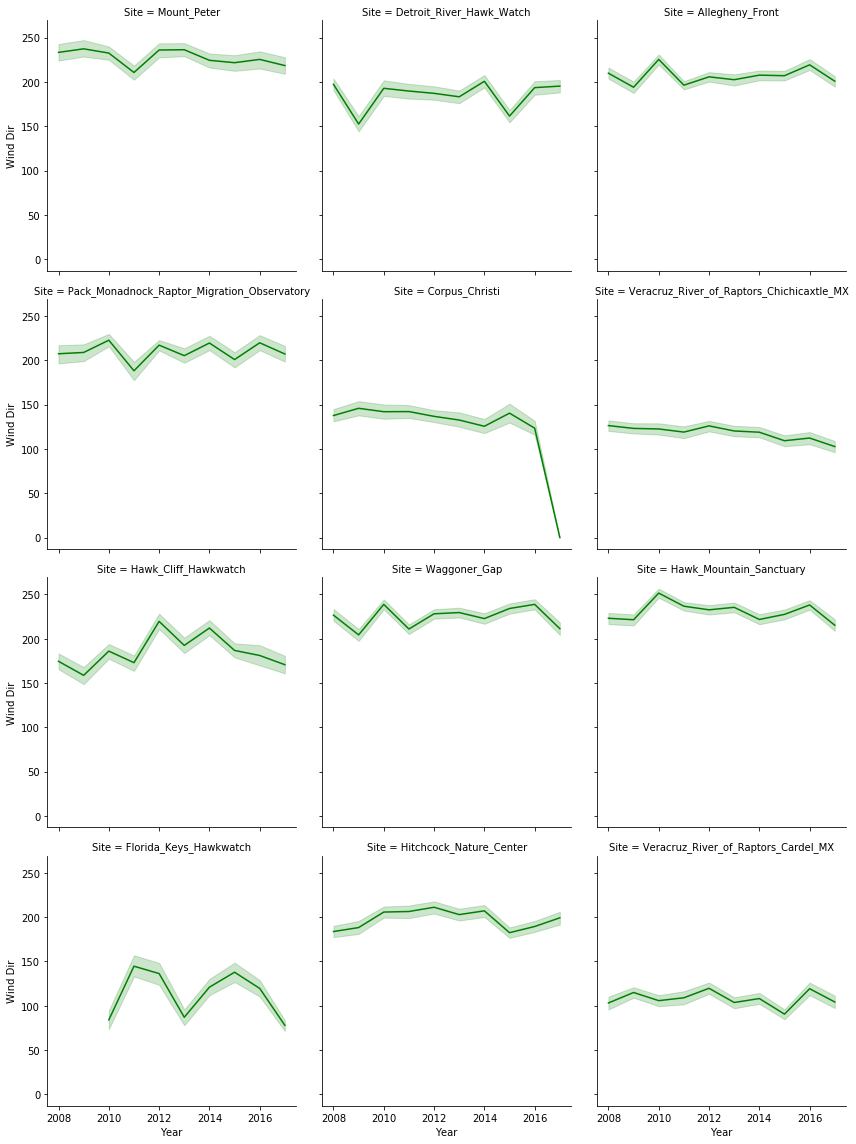

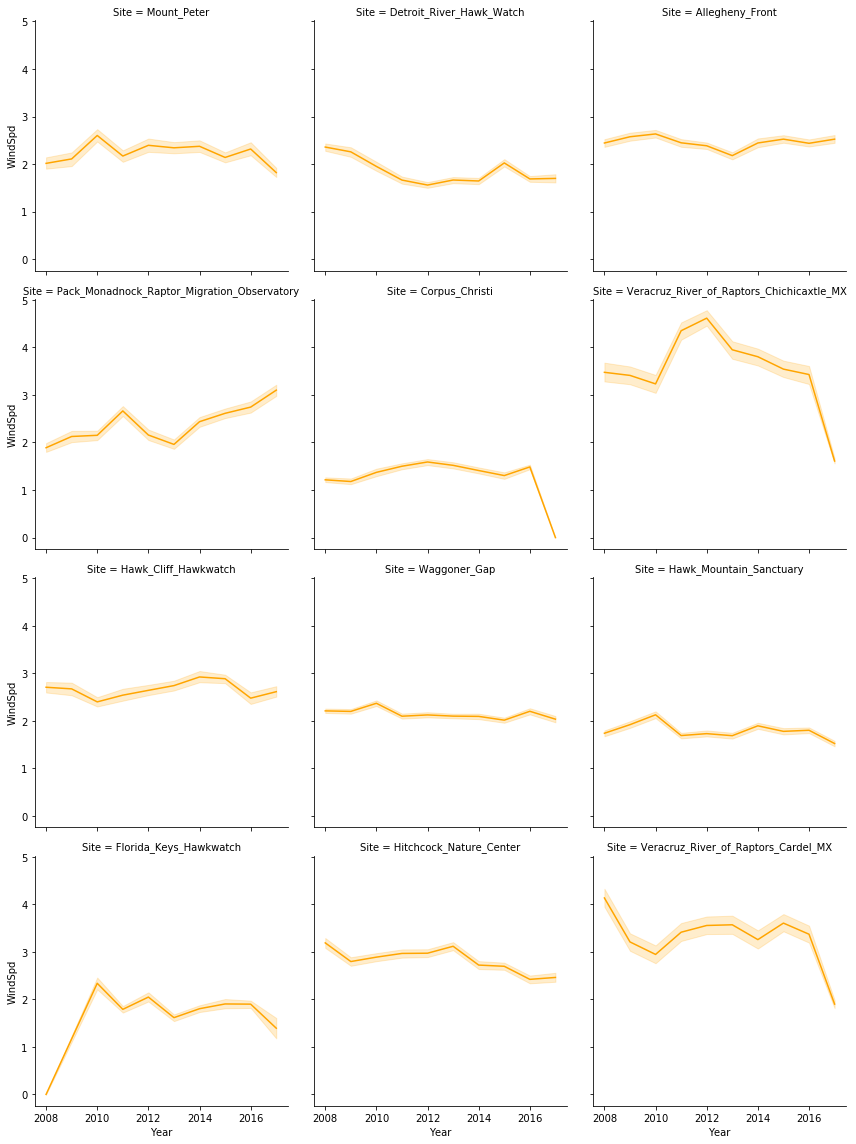

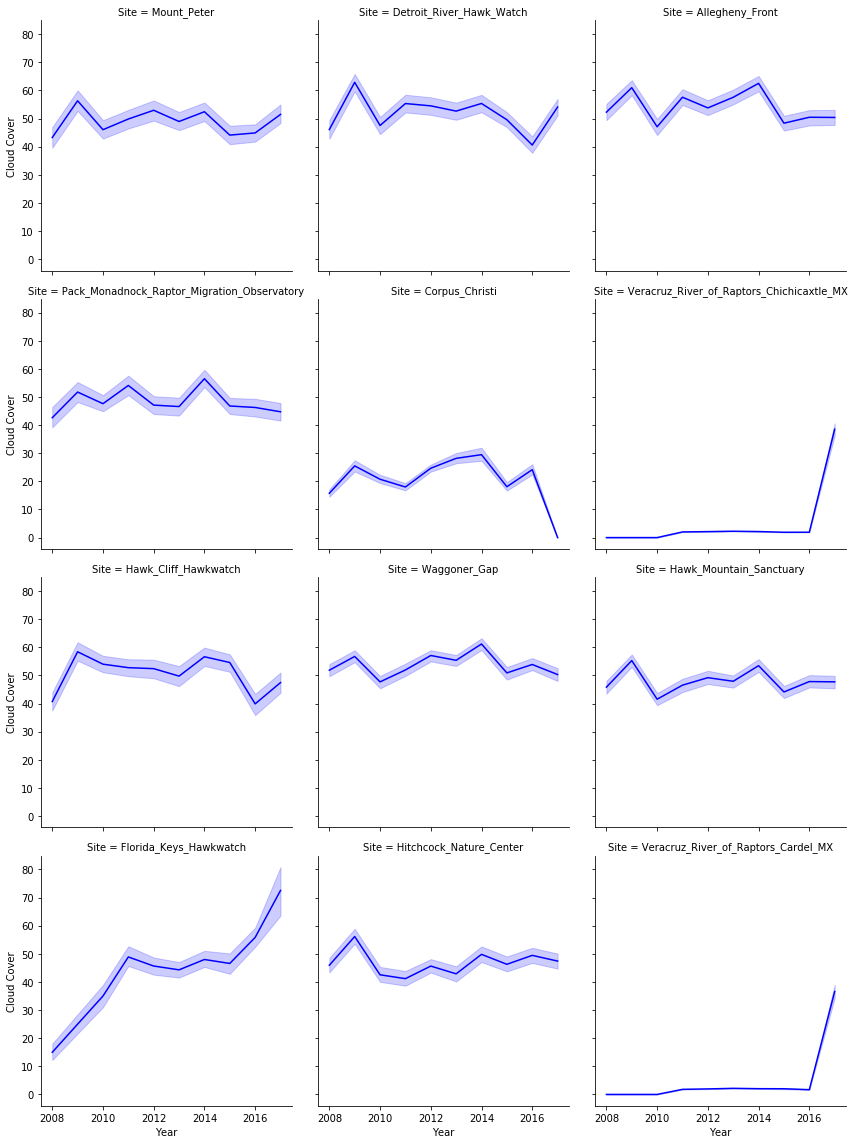

In [4]:
Climatic_Vars = ['Wind Dir', 'WindSpd', 'Cloud Cover']
colors = ['green', 'orange', 'blue']

for var, c in zip(Climatic_Vars, colors):
    sns.relplot(x = 'Year', y = var, col = 'Site',
                col_wrap = 3, height = 4, kind = 'line',
                data = Total_Data, color = c);
    
# Note: include - estimator = None - as argument to turn off aggregation altogether
# -- multiple observation at each year --


* Separate count data per species and plot by site

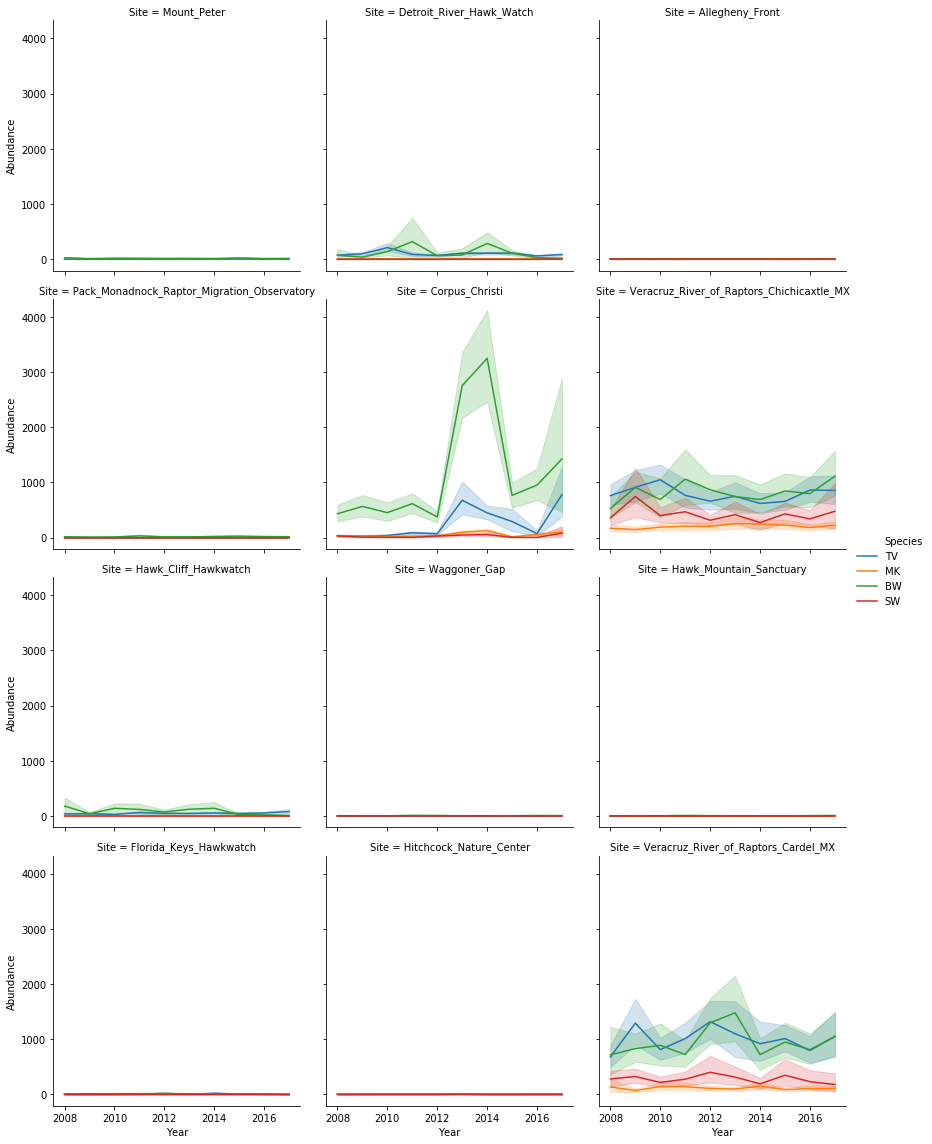

In [5]:
################# Species: Cathartes aura (TV) #################

Subset_TV = Total_Data.loc[:, ~Total_Data.columns.isin(['MK',
                                                        'BW', 
                                                        'SW'])]
Subset_TV['Species'] = 'TV' # add a new column with TV
Subset_TV = Subset_TV.rename(columns = {'TV': 'Abundance'})



# ############### Species: Ictinia mississippiensis (MK) ################

Subset_MK = Total_Data.loc[:, ~Total_Data.columns.isin(['TV', 
                                                        'BW', 
                                                        'SW'])]
Subset_MK['Species'] = 'MK'
Subset_MK = Subset_MK.rename(columns = {'MK': 'Abundance'})


############### Species: Buteo platypterus (BW) ################

Subset_BW = Total_Data.loc[:, ~Total_Data.columns.isin(['TV', 
                                                        'MK', 
                                                        'SW'])]
Subset_BW['Species'] = 'BW'
Subset_BW = Subset_BW.rename(columns = {'BW': 'Abundance'})


############### Species: Buteo swainsoni (SW) ################

Subset_SW = Total_Data.loc[:, ~Total_Data.columns.isin(['TV', 
                                                        'MK', 
                                                        'BW'])]
Subset_SW['Species'] = 'SW'
Subset_SW = Subset_SW.rename(columns = {'SW': 'Abundance'})



## Concatenate all subsets and plot abundance by species

NewData = pd.concat([Subset_TV, Subset_MK, Subset_BW, Subset_SW])

sns.relplot(x = 'Year', y = 'Abundance', col = 'Site', hue = 'Species', 
            col_wrap = 3, height = 4, kind = 'line',data = NewData);


From these plots we can notice that there are sites without observations for some species (0 values), besides previously detected NA values. We can still refine visualization using heatmaps to plot embedded time intervals.

## Heatmaps

In order to look for patterns in counts and climate variables we need:

* Dataframes separated by species:  

We will use the subsets per species generated above (Subset_TV, Subset_MK, Subset_BW, Subset_SW)

* Dataframe separated by site:

To separate data by site we will use the argument *'col'* from *seaborn.FaceGrid* function.

* A new structure of dataframes indicating the time scales to display in heatmaps:

We need to reorder the dataframes structure, which is easy using **pivot_table** from pandas. The arguments we will use are:

**index:** variables used to separate data.  
**columns:** the levels for this variable will be the new columns.  
**values:** correspond to rows in the new dataframe.  
**aggfunc:** function to be applied on values.  

The following table shows an example of the structure we want for dataframes:

In [87]:
print('Pivot table for TV counts data')
pd.pivot_table(Subset_TV, index = 'Month', columns = 'Year', values = 'Abundance', aggfunc = ['sum'])

Pivot table for TV counts data


sum                                                                 \
Year      2008     2009     2010     2011     2012     2013     2014     2015   
Month                                                                           
8          162       84      160       42       77       75       45       11   
9        42234    39987    50239    55845    50113    17802     8173    10080   
10     1235954  1834233  1576333  1659558  1793864  1897626  1449198  1399702   
11       90643   107084   106681    97217   128861   298953   344884   416695   
12          10       10        4       51       37       25       26       40   

                         
Year      2016     2017  
Month                    
8           44       19  
9         8124    16737  
10     1365754  1711018  
11      278267   151223  
12           8        7

Create a function to draw heatmap using a pivot table

In [89]:
def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d = pd.pivot_table(data, 
                       index = args[1], 
                       columns = args[0],
                       values = args[2], 
                       aggfunc = 'sum')
    sns.set(font_scale=1.3)
    sns.heatmap(d, **kwargs, cmap = 'BuPu')

## Count data

###  *Cathartes aura* 

<img src="images/TV.png" width="300"/>

#### Patterns in abundance by day of the month

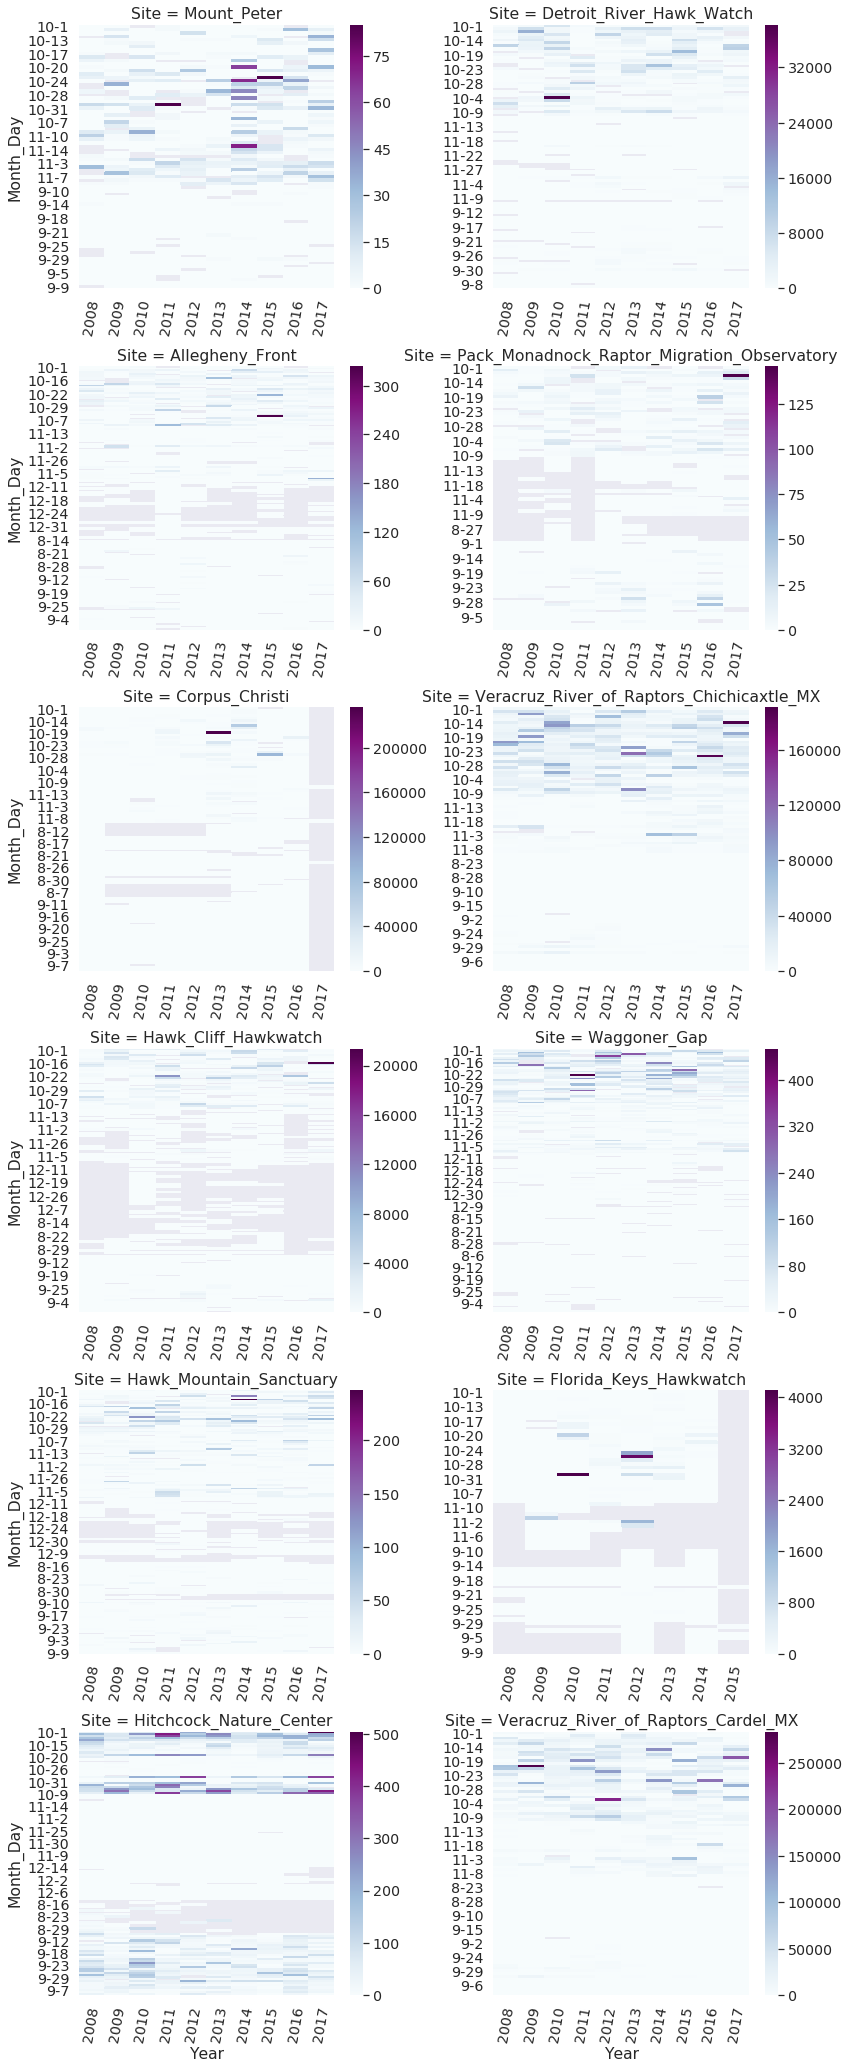

In [96]:
gtv = sns.FacetGrid(Subset_TV, col = 'Site', col_wrap = 2, 
                    sharey = False, sharex = False, 
                    height = 5, aspect = 1.2)
gtv.map_dataframe(draw_heatmap, 'Year', 'Month_Day', 'Abundance');
gtv.set_xticklabels(rotation = 80);
plt.subplots_adjust(top = 0.95);

#### Patterns in abundance by month

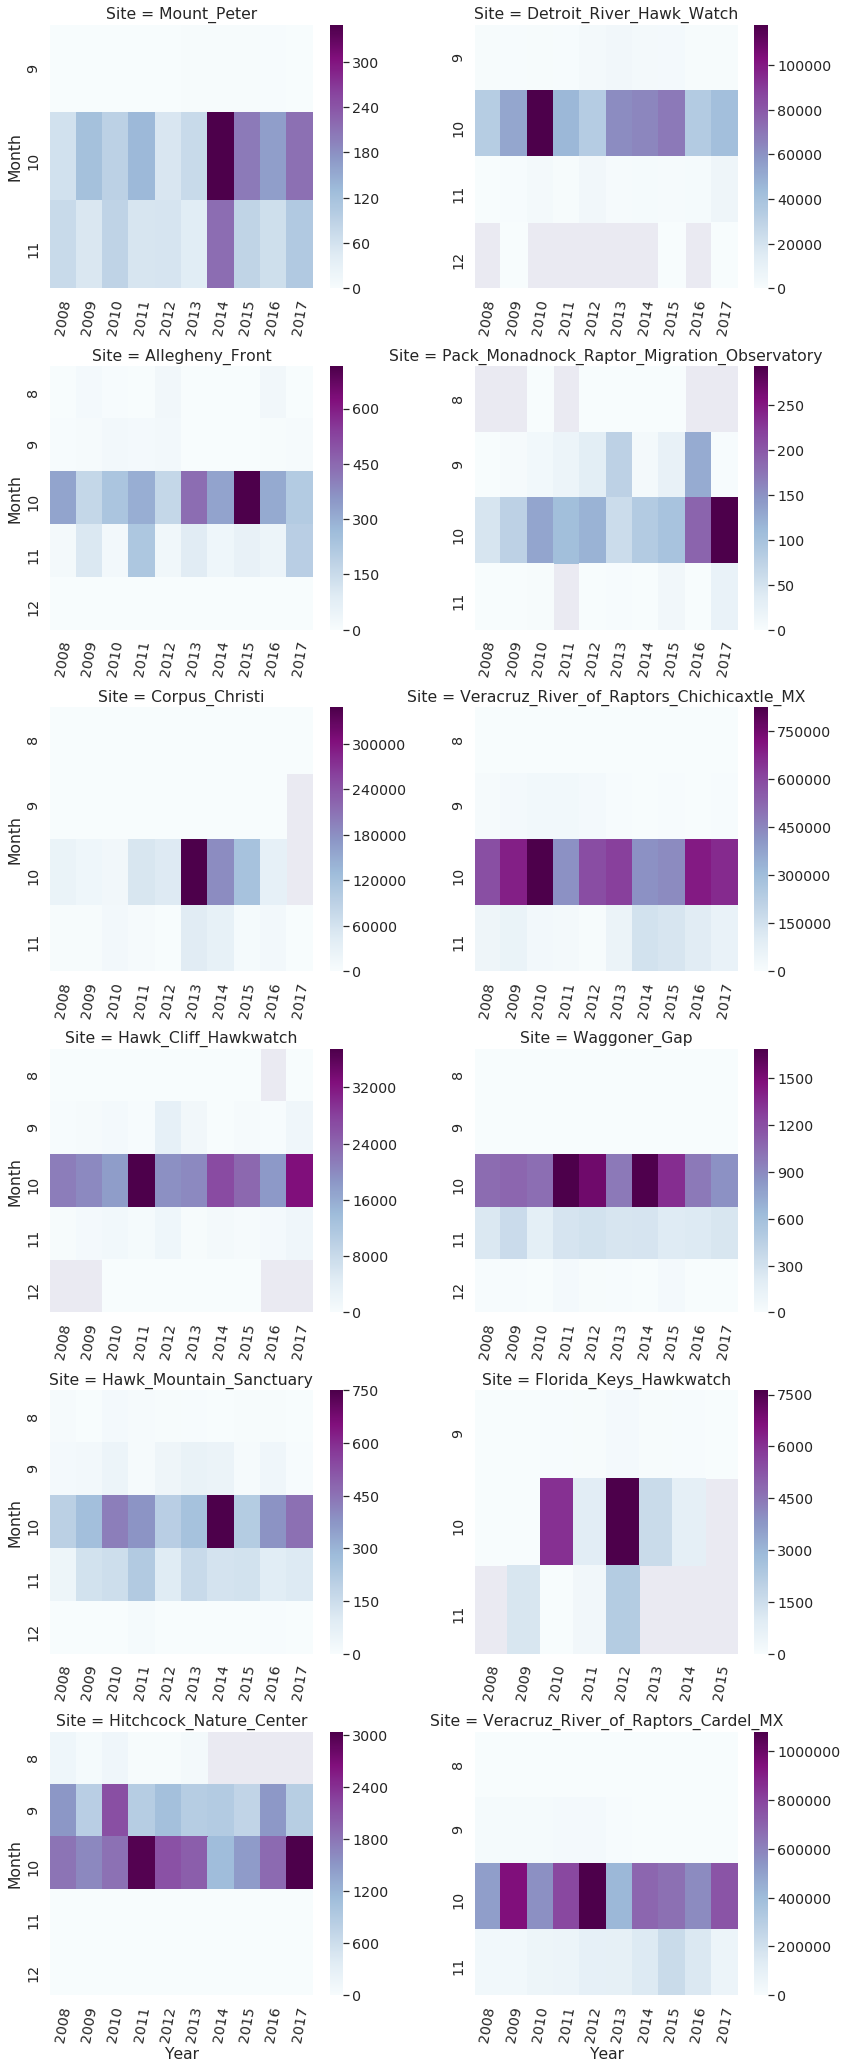

In [95]:
gtv = sns.FacetGrid(Subset_TV, col = 'Site', col_wrap = 2, 
                    sharey = False, sharex = False, 
                    height = 5, aspect = 1.2)
gtv.map_dataframe(draw_heatmap, 'Year', 'Month', 'Abundance');
gtv.set_xticklabels(rotation = 80);
plt.subplots_adjust(top = 0.95);

###  *Ictinia mississippiensis* 

<img src="images/MK.png"/>

For MK is necessary to remove sites where this species is no present.

#### Patterns in abundance by day of the month

In [90]:
NotPresent = ['Mount_Peter', 'Detroit_River_Hawk_Watch',
              'Allegheny_Front', 'Hawk_Cliff_Hawkwatch',
              'Hawk_Mountain_Sanctuary', 
              'Pack_Monadnock_Raptor_Migration_Observatory', 
              'Waggoner_Gap']

Subset2_MK = Subset_MK[~Subset_MK.Site.isin(NotPresent)] 


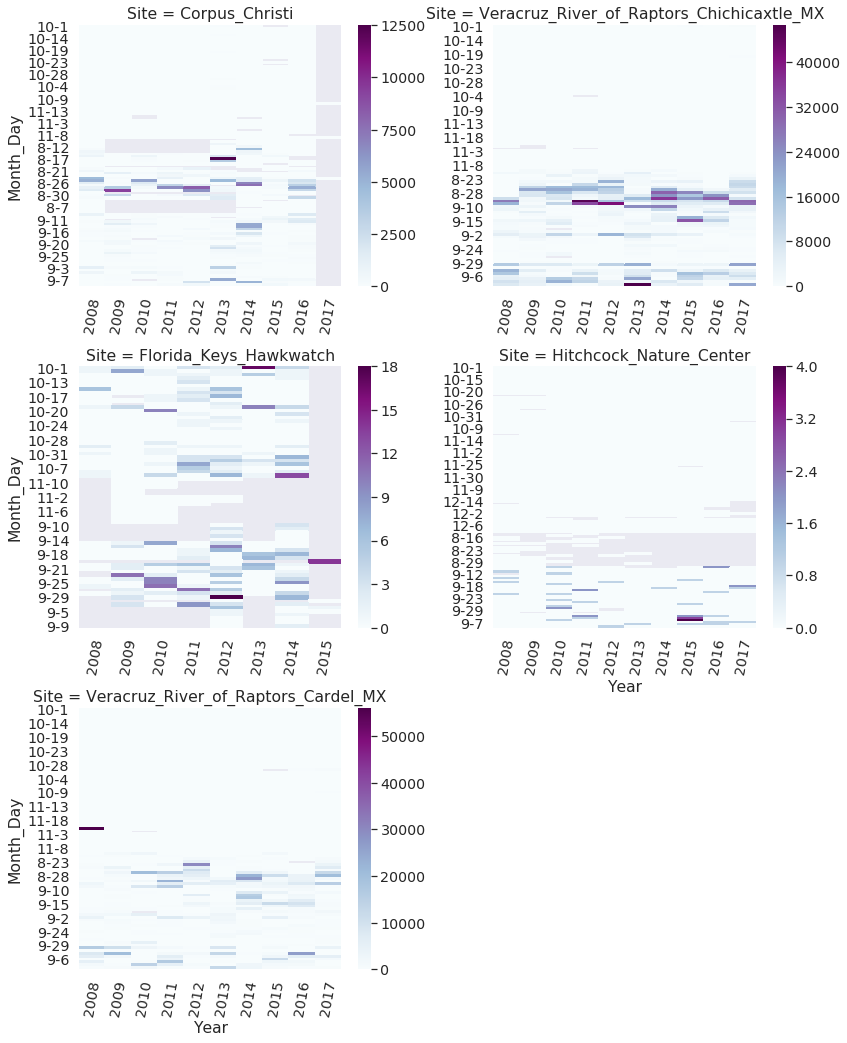

In [94]:
gtv = sns.FacetGrid(Subset2_MK, col = 'Site', col_wrap = 2, 
                    sharey = False, sharex = False, 
                    height = 5, aspect = 1.2)
gtv.map_dataframe(draw_heatmap, 'Year', 'Month_Day', 'Abundance');
gtv.set_xticklabels(rotation = 80);
plt.subplots_adjust(top = 0.95);


#### Patterns in abundance by month

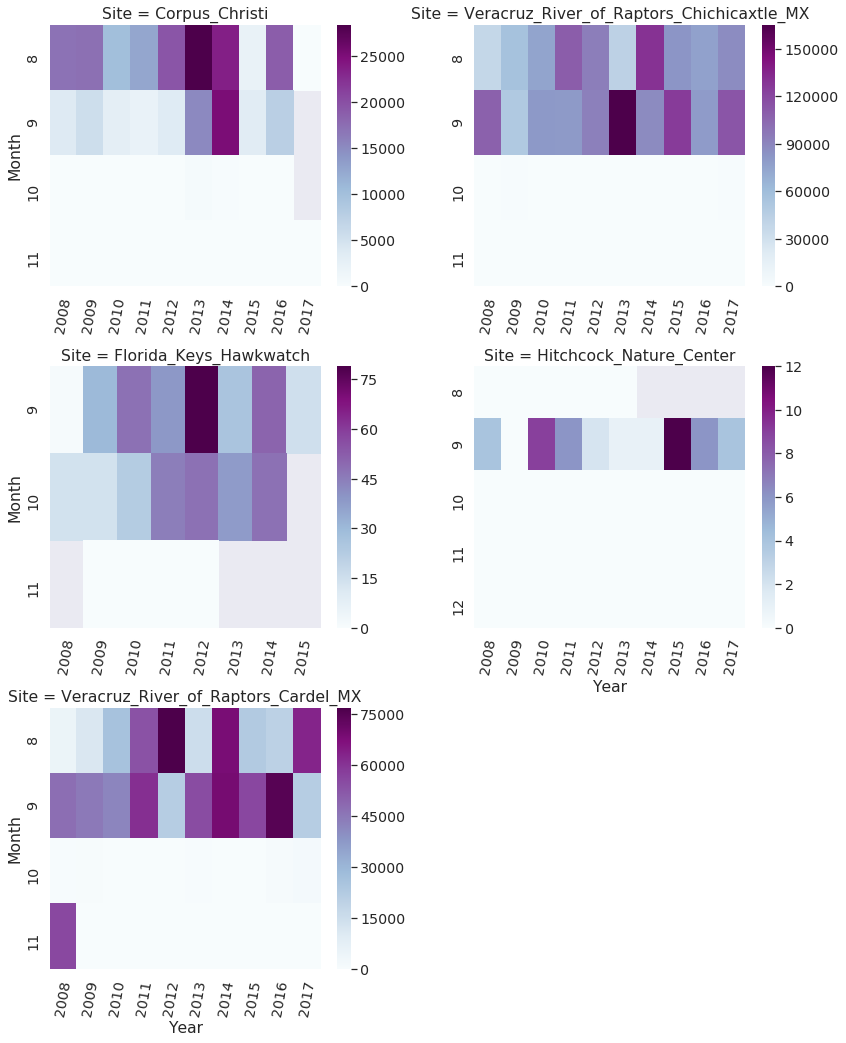

In [93]:
gtv = sns.FacetGrid(Subset2_MK, col = 'Site', col_wrap = 2, 
                    sharey = False, sharex = False, 
                    height = 5, aspect = 1.2)
gtv.map_dataframe(draw_heatmap, 'Year', 'Month', 'Abundance');
gtv.set_xticklabels(rotation = 80);
plt.subplots_adjust(top = 0.95);


### *Buteo platypterus*

<img src="images/BW.png" width="500"/>

#### Patterns in abundance by day of the month

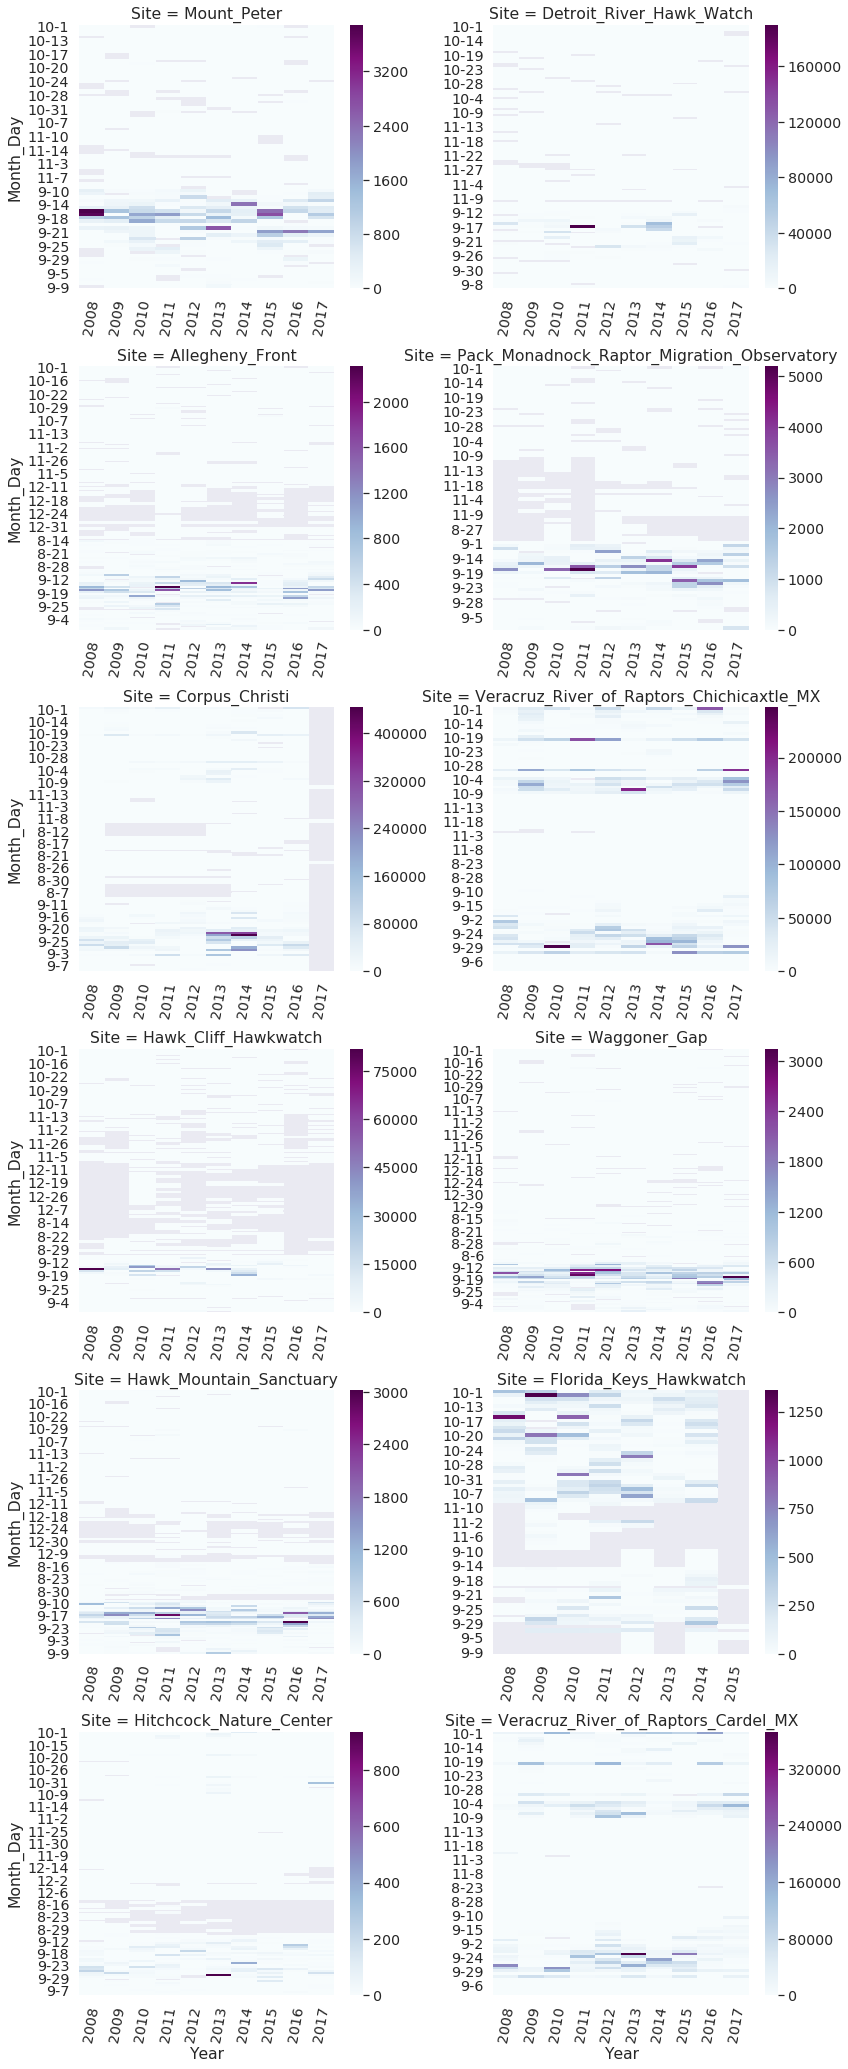

In [97]:
gtv = sns.FacetGrid(Subset_BW, col = 'Site', col_wrap = 2, 
                    sharey = False, sharex = False, 
                    height = 5, aspect = 1.2)
gtv.map_dataframe(draw_heatmap, 'Year', 'Month_Day', 'Abundance');
gtv.set_xticklabels(rotation = 80);
plt.subplots_adjust(top = 0.95);

#### Patterns in abundance by month

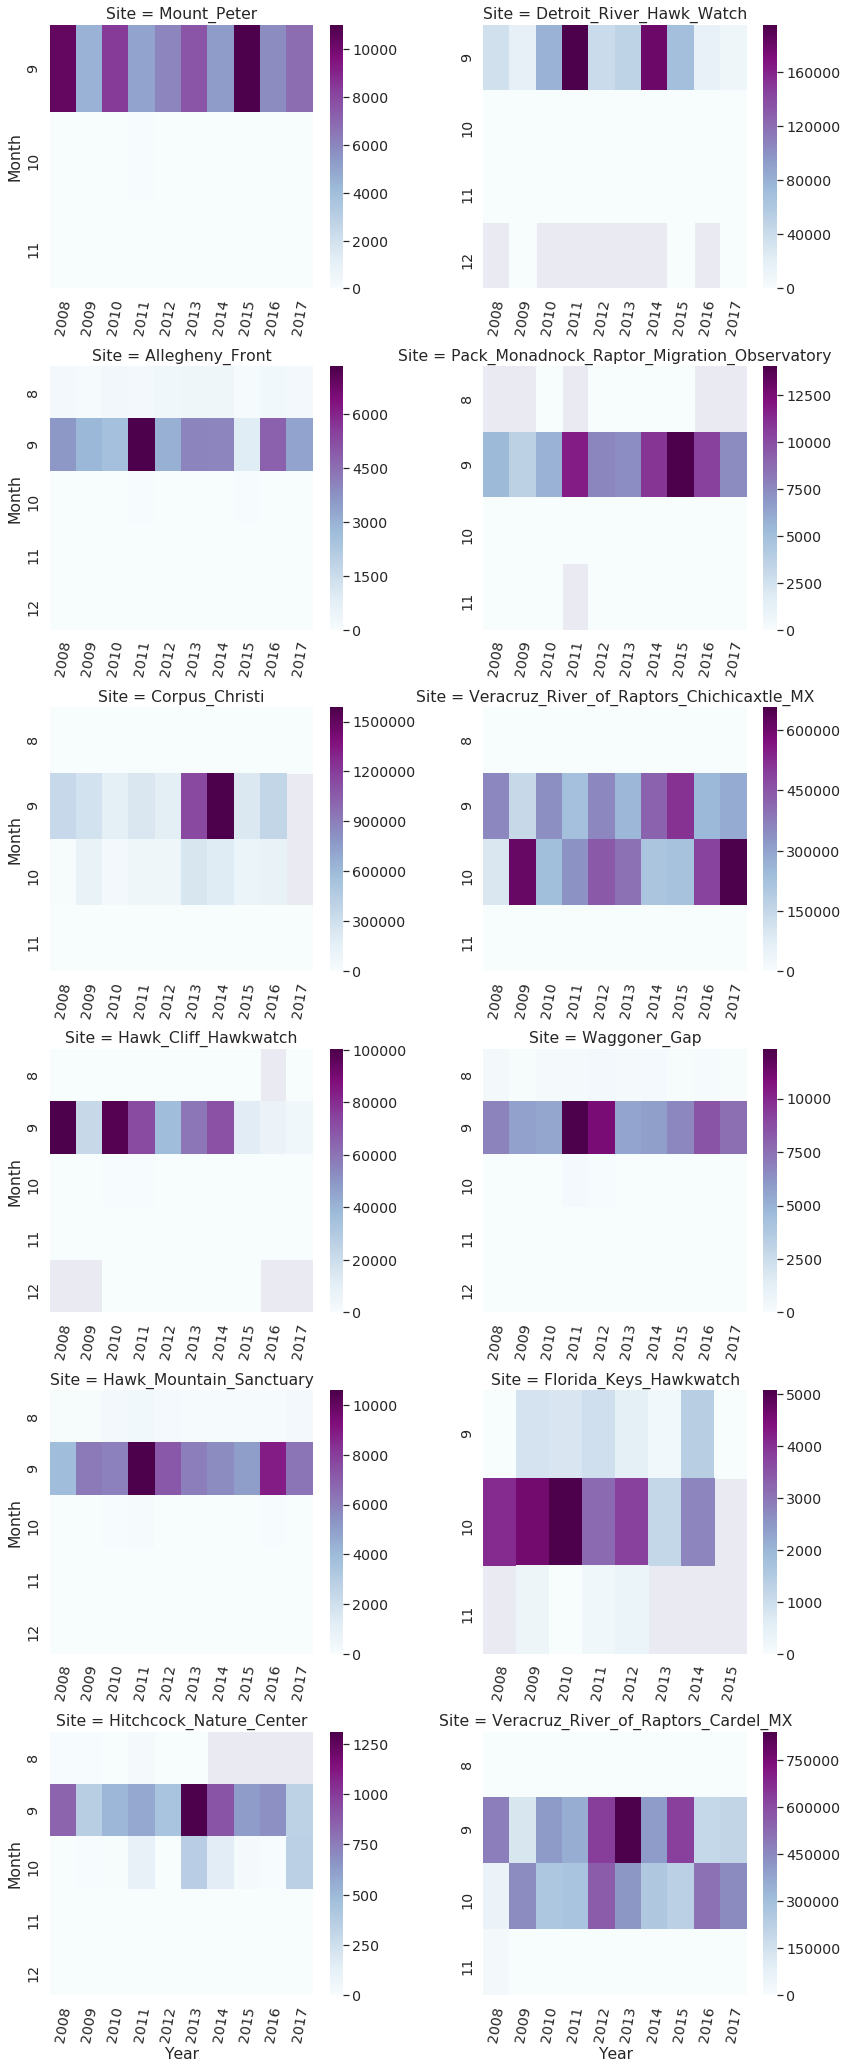

In [98]:
gtv = sns.FacetGrid(Subset_BW, col = 'Site', col_wrap = 2, 
                    sharey = False, sharex = False, 
                    height = 5, aspect = 1.2)
gtv.map_dataframe(draw_heatmap, 'Year', 'Month', 'Abundance');
gtv.set_xticklabels(rotation = 80);
plt.subplots_adjust(top = 0.95);

###  *Buteo swainsoni* 

<img src="images/SW.png" width="400"/> 

For SW is necessary to remove sites where this species is no present.

#### Patterns in abundance by day of the month

In [29]:
NotPresent = ['Mount_Peter', 'Allegheny_Front', 
              'Pack_Monadnock_Raptor_Migration_Observatory', 
              'Waggoner_Gap']

Subset2_SW = Subset_SW[~Subset_SW.Site.isin(NotPresent)] 

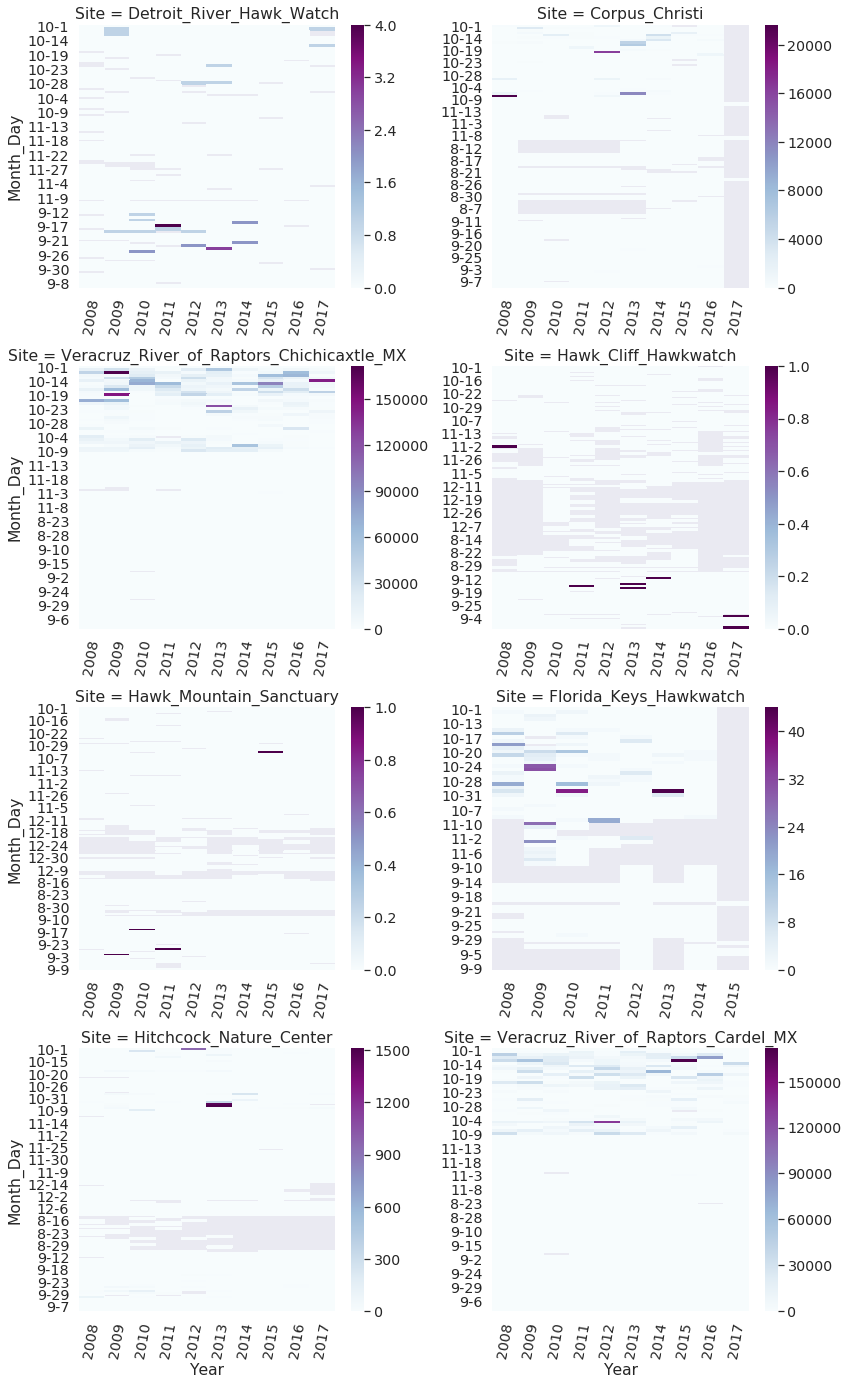

In [99]:
gtv = sns.FacetGrid(Subset2_SW, col = 'Site', col_wrap = 2, 
                    sharey = False, sharex = False, 
                    height = 5, aspect = 1.2)
gtv.map_dataframe(draw_heatmap, 'Year', 'Month_Day', 'Abundance');
gtv.set_xticklabels(rotation = 80);
plt.subplots_adjust(top = 0.95);

#### Patterns in abundance by month

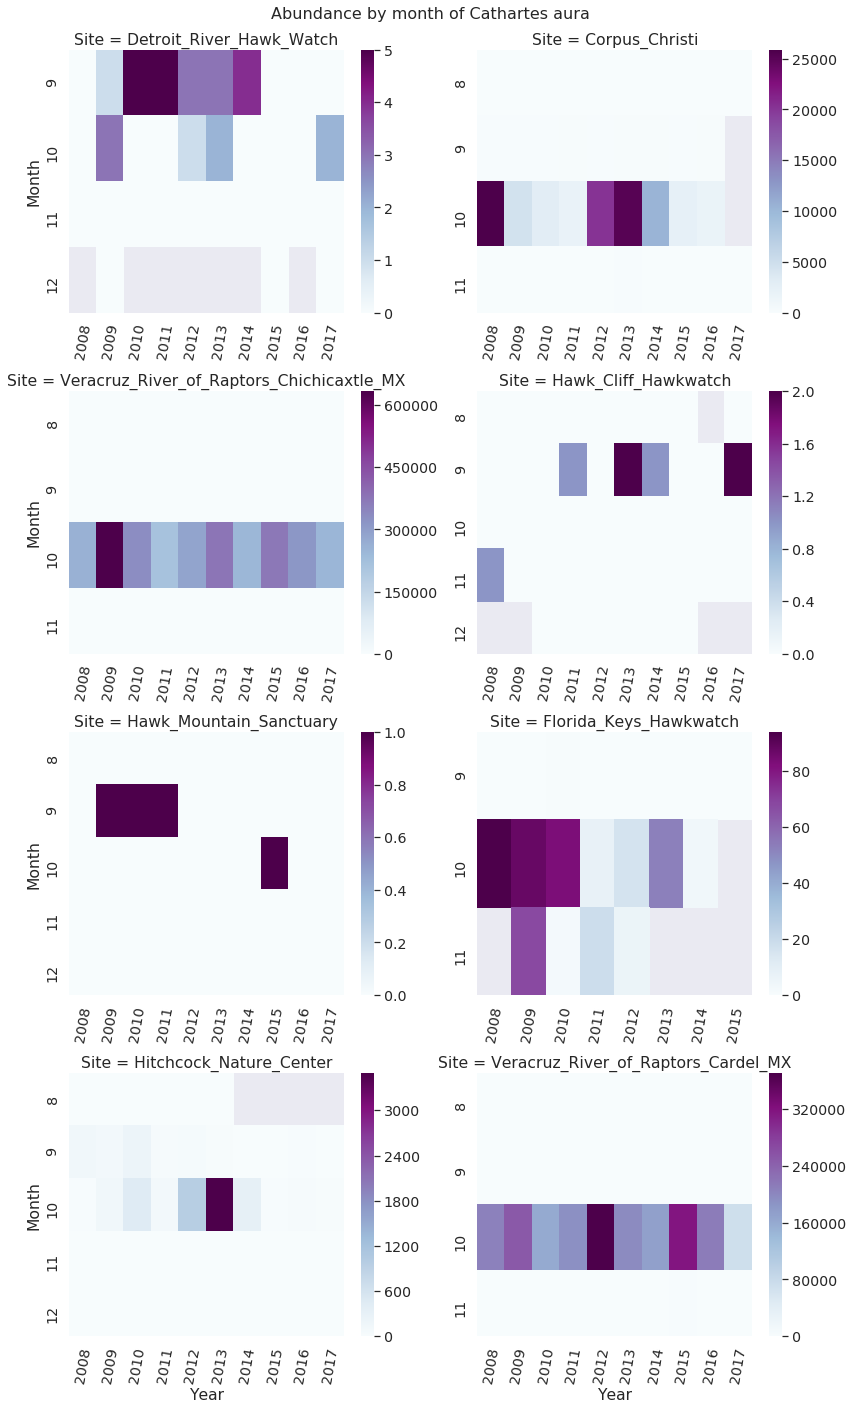

In [31]:
gtv = sns.FacetGrid(Subset2_SW, col = 'Site', col_wrap = 2, 
                    sharey = False, sharex = False, 
                    height = 5, aspect = 1.2)
gtv.map_dataframe(draw_heatmap, 'Year', 'Month', 'Abundance');
gtv.set_xticklabels(rotation = 80);
plt.subplots_adjust(top = 0.95);
gtv.fig.suptitle('Abundance by month of Cathartes aura', fontsize = 16);

## Climate Variables

Create a function to plot a heatmap for climate variables using a pivot table (calculating means)

In [101]:
def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d = pd.pivot_table(data, 
                       index = args[1], 
                       columns = args[0],
                       values = args[2], 
                       aggfunc = 'mean')
    sns.set(font_scale=1.3)
    sns.heatmap(d, **kwargs, cmap = 'GnBu')

### Wind Direction

#### Patterns by day of the month

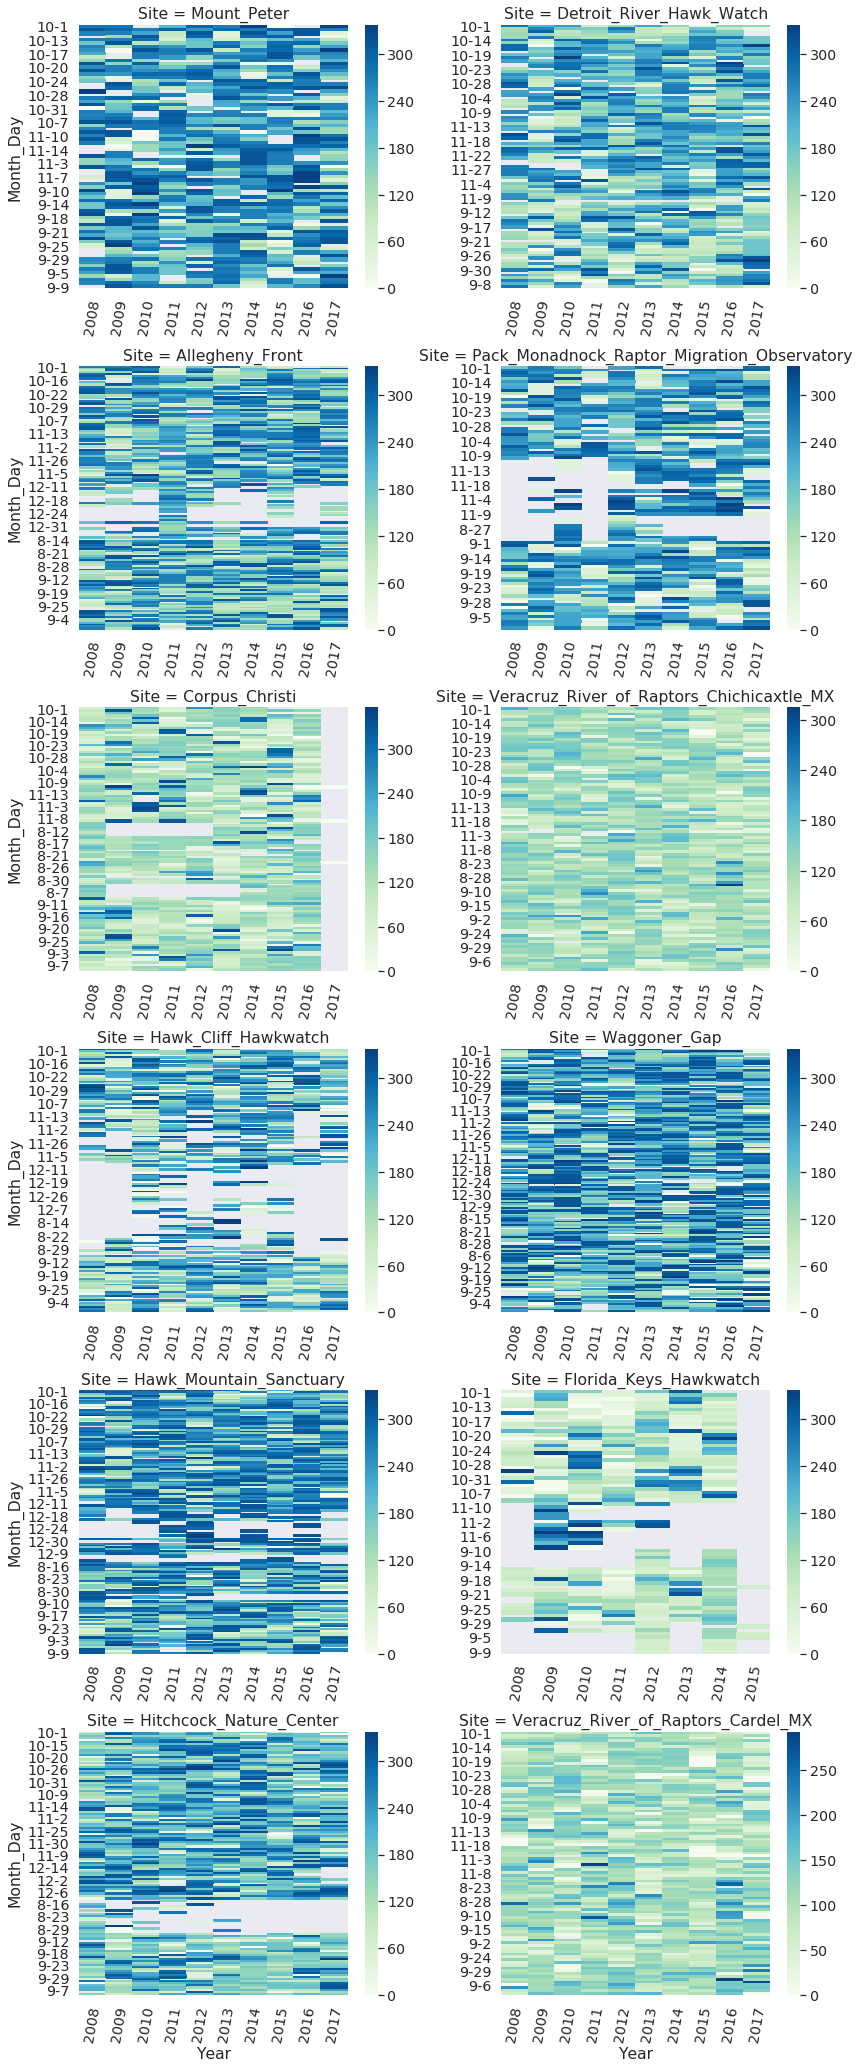

In [102]:
gwd = sns.FacetGrid(Subset_TV, col = 'Site', col_wrap = 2, 
                    sharey = False, sharex = False, 
                    height = 5, aspect = 1.2)

gwd.map_dataframe(draw_heatmap, 'Year', 'Month_Day', 'Wind Dir');
gwd.set_xticklabels(rotation = 80);
plt.subplots_adjust(top = 0.95);

#### Patterns by month

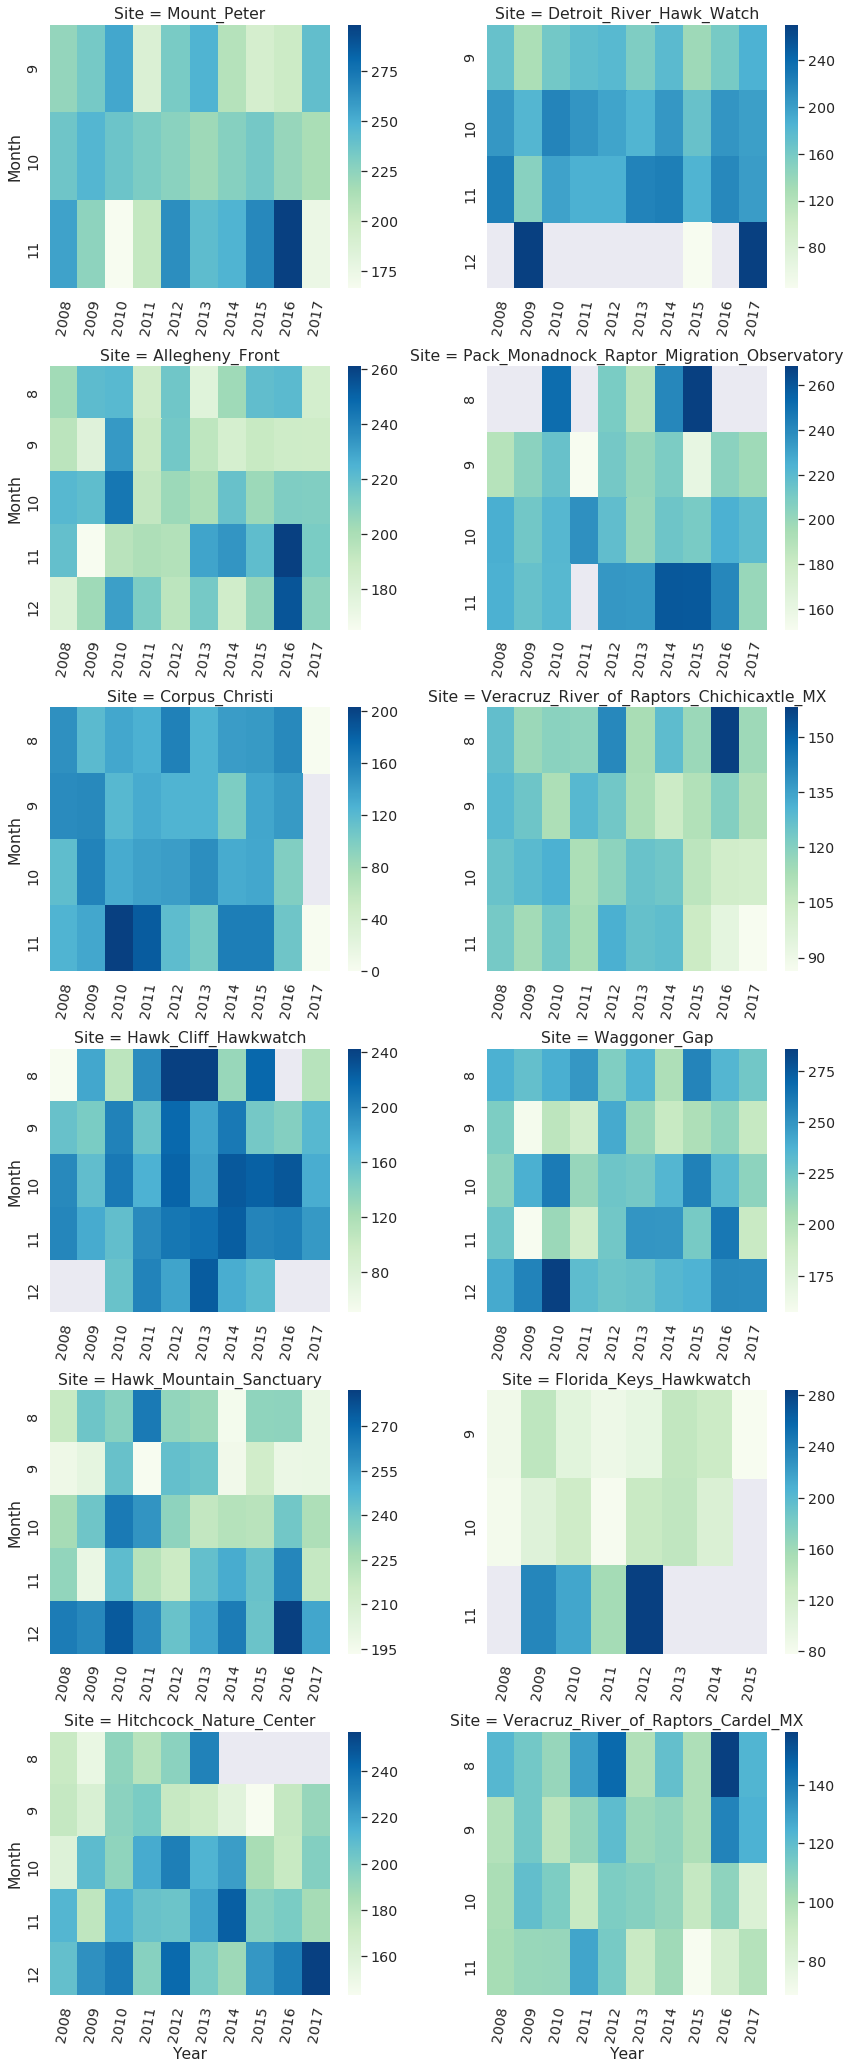

In [103]:
gwd = sns.FacetGrid(Subset_TV, col = 'Site', col_wrap = 2, 
                    sharey = False, sharex = False, 
                    height = 5, aspect = 1.2)
gwd.map_dataframe(draw_heatmap, 'Year', 'Month', 'Wind Dir');
gwd.set_xticklabels(rotation = 80);
plt.subplots_adjust(top = 0.95);

### Wind Speed

#### Patterns  by day of the month

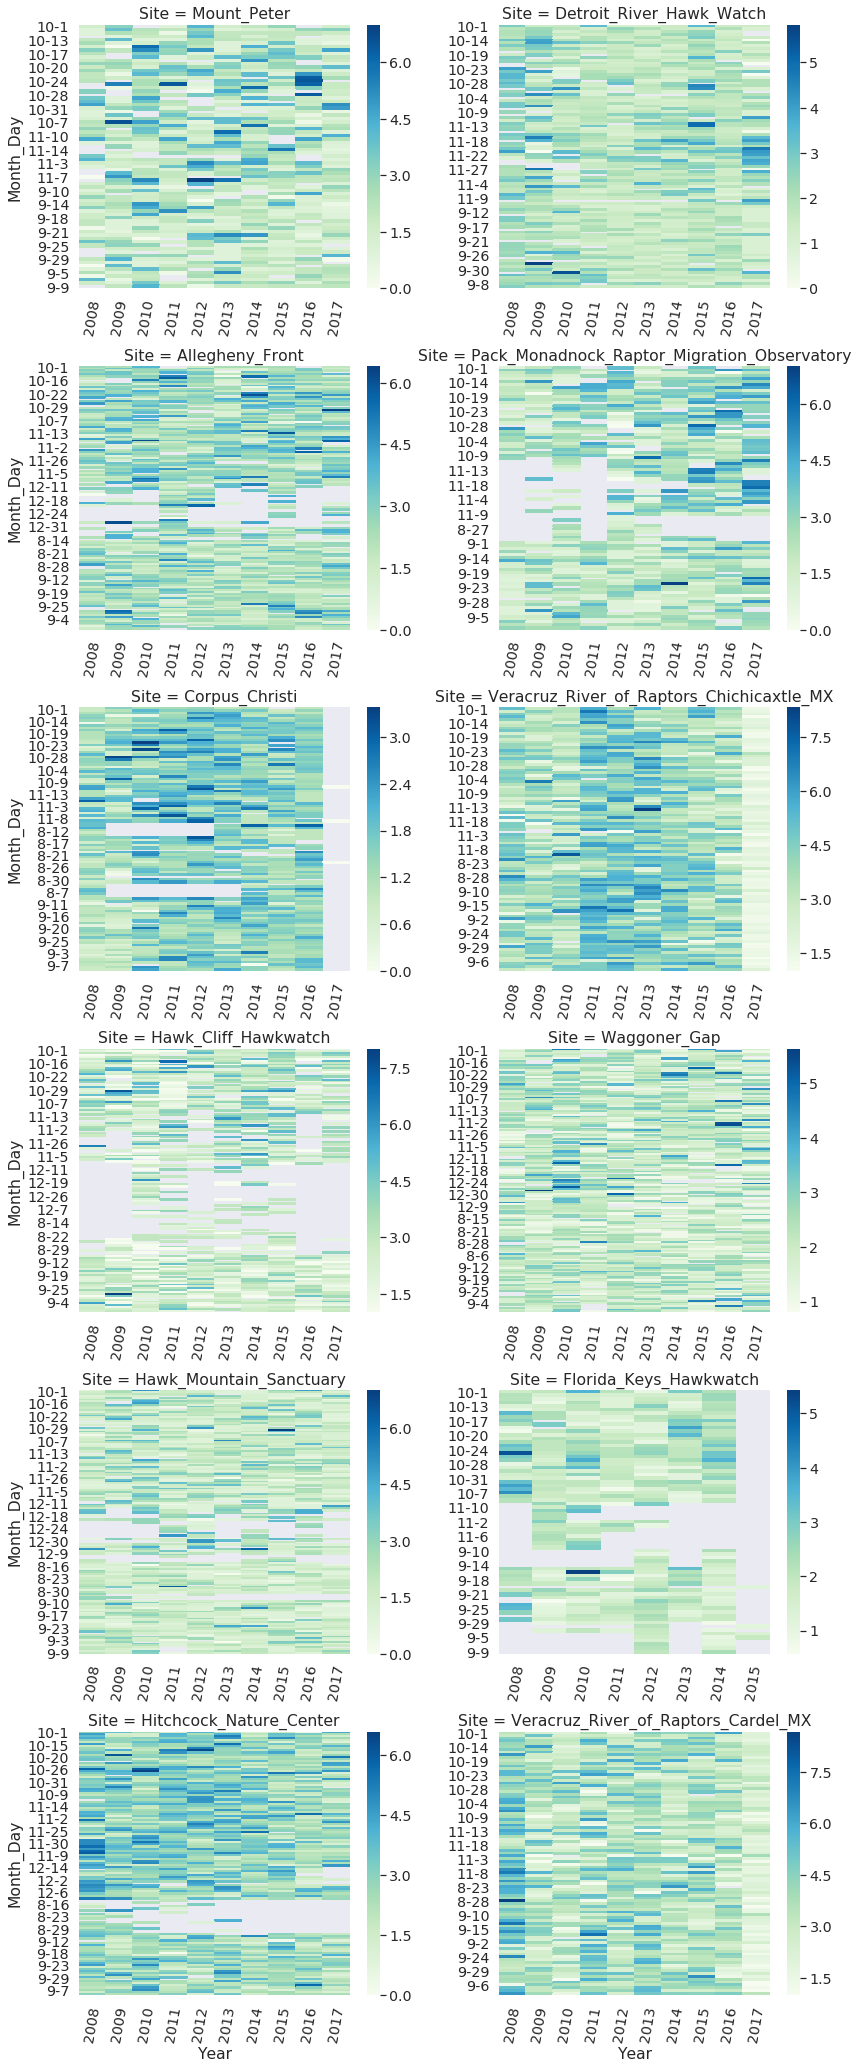

In [104]:
gws = sns.FacetGrid(Subset_TV, col = 'Site', col_wrap = 2, 
                    sharey = False, sharex = False, 
                    height = 5, aspect = 1.2)
gws.map_dataframe(draw_heatmap, 'Year', 'Month_Day', 'WindSpd');
gws.set_xticklabels(rotation = 80);
plt.subplots_adjust(top = 0.95);

#### Patterns by month

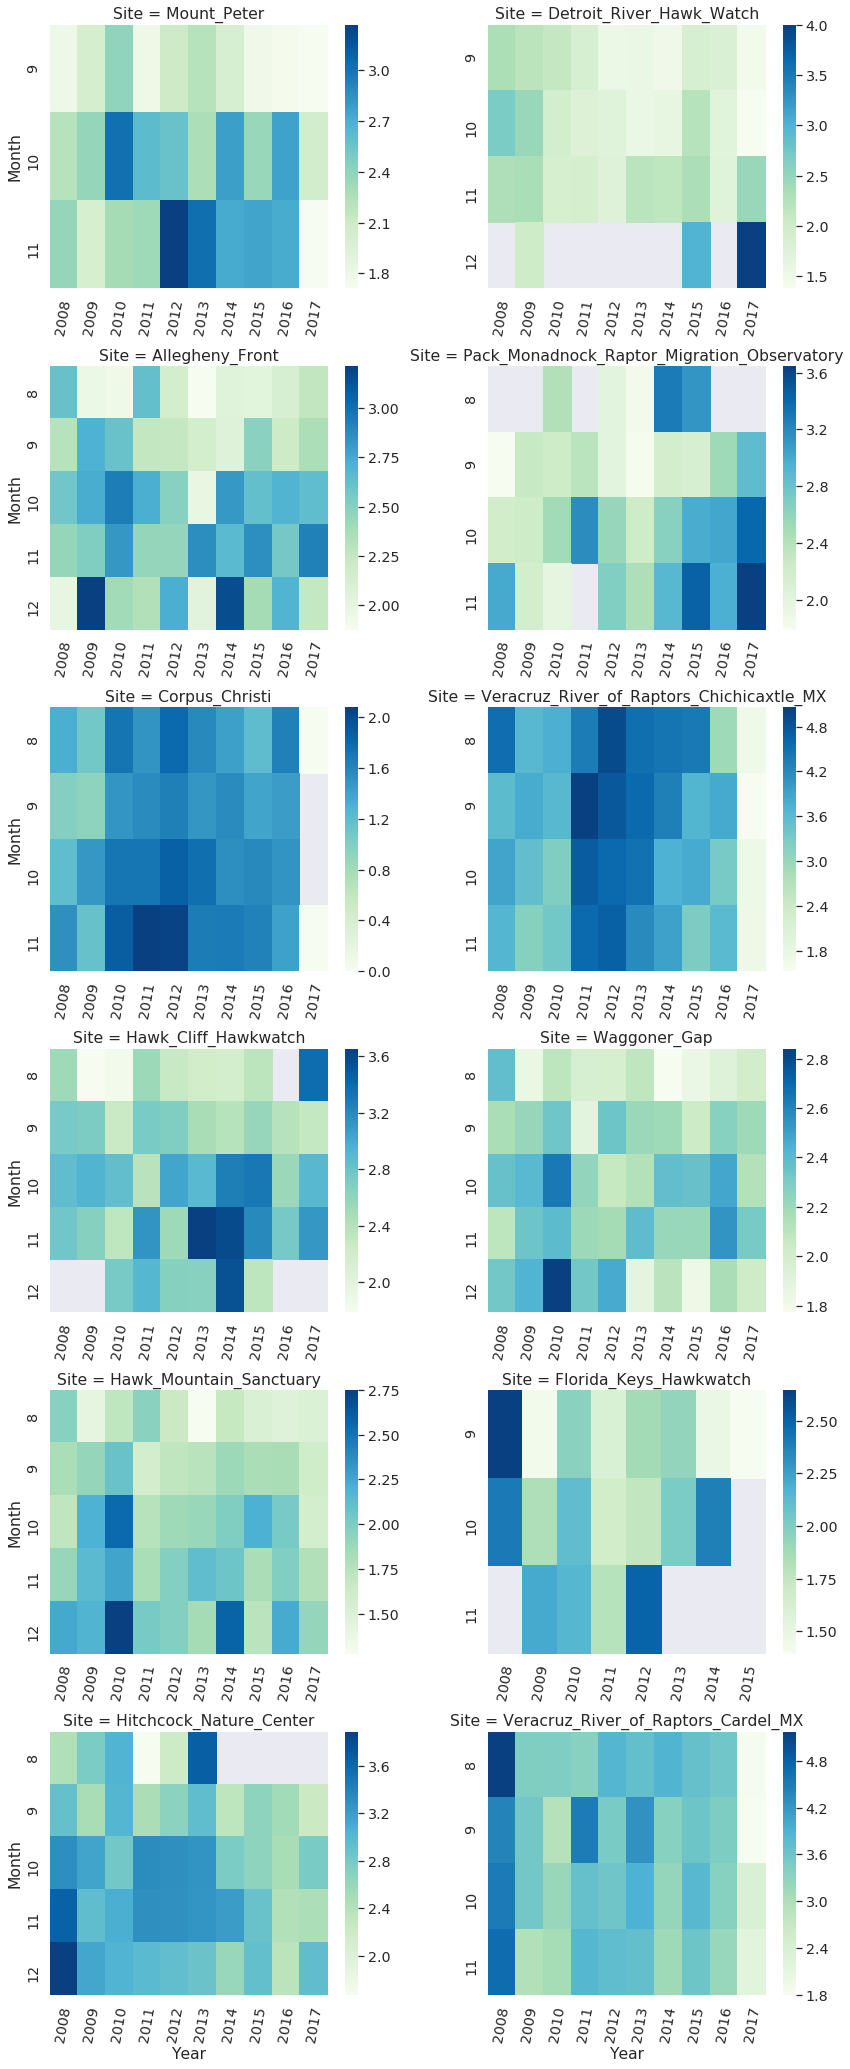

In [105]:
gws = sns.FacetGrid(Subset_TV, col = 'Site', col_wrap = 2, 
                    sharey = False, sharex = False, 
                    height = 5, aspect = 1.2)
gws.map_dataframe(draw_heatmap, 'Year', 'Month', 'WindSpd');
gws.set_xticklabels(rotation = 80);
plt.subplots_adjust(top = 0.95);

### Cloud Cover

#### Patterns  by day of the month

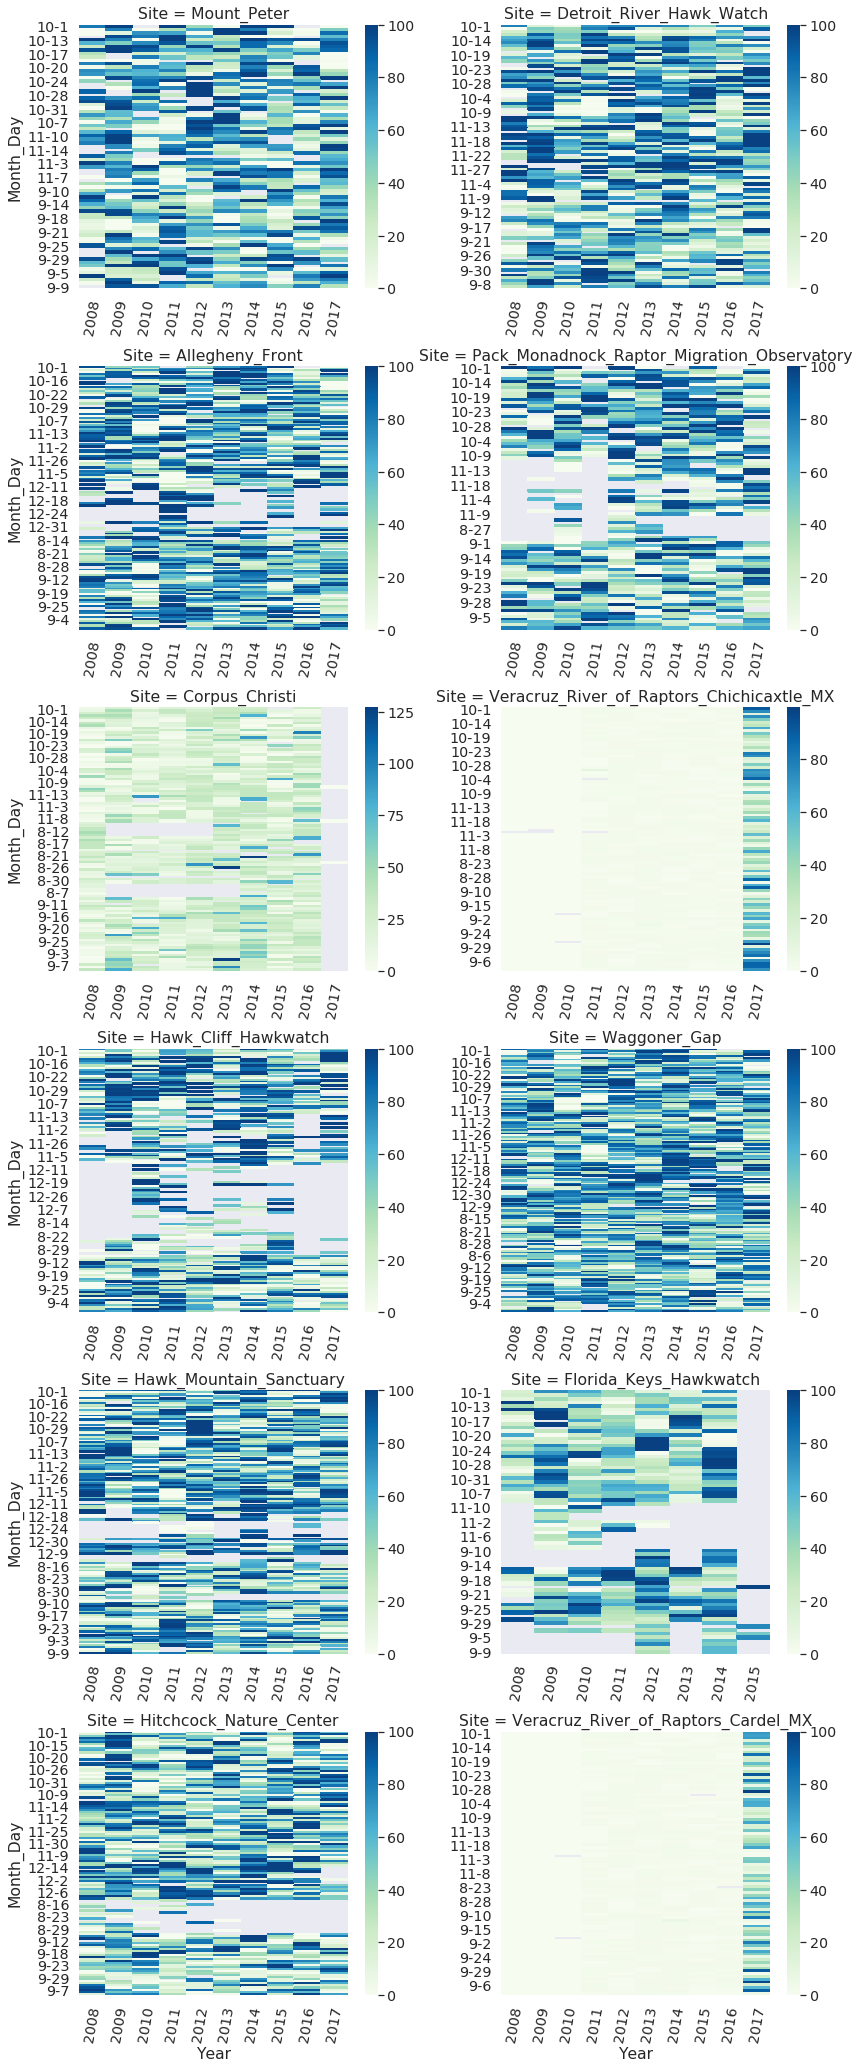

In [106]:
gcc = sns.FacetGrid(Subset_TV, col = 'Site', col_wrap = 2, 
                    sharey = False, sharex = False, 
                    height = 5, aspect = 1.2)
gcc.map_dataframe(draw_heatmap, 'Year', 'Month_Day', 'Cloud Cover');
gcc.set_xticklabels(rotation = 80);
plt.subplots_adjust(top = 0.95);

#### Patterns by month

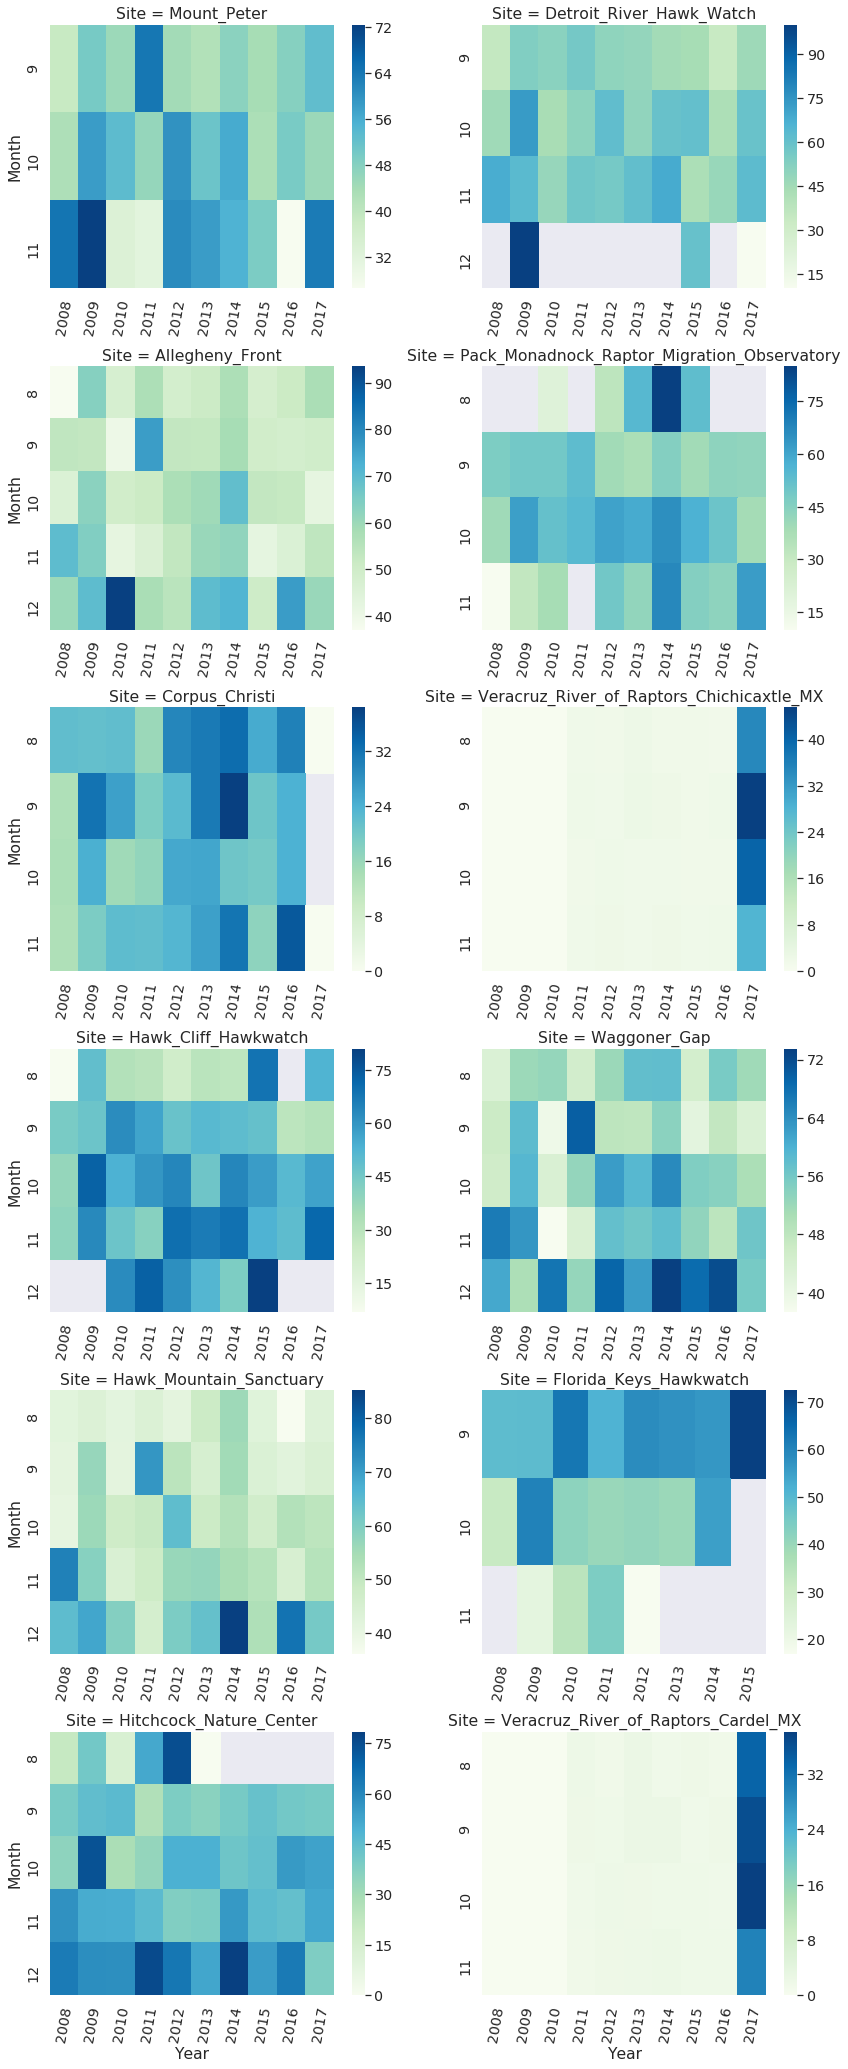

In [107]:
gcc = sns.FacetGrid(Subset_TV, col = 'Site', col_wrap = 2, 
                    sharey = False, sharex = False, 
                    height = 5, aspect = 1.2)
gcc.map_dataframe(draw_heatmap, 'Year', 'Month', 'Cloud Cover');
gcc.set_xticklabels(rotation = 80);
plt.subplots_adjust(top = 0.95);